In [1]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner


In [2]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N])
    return state


def Gompertz(a,b,c,l=150):
    t = tt.arange(l)
    return a*tt.exp(-b*tt.exp(-c*t))

In [3]:
# Data from
#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Germany,51.165690999999995,10.451526,
jhu_deaths = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,7,9,11,17,24,28,44,67,84,94,123,157,206,267,342,433,533,645,775,920,1107,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052,4352,4459,4586,4862,5033,5279,5575,5760,5877,5976,6126,6314,6467,6623,6736,6812,6866,6993,6993,7275,7392,7510,7549,7569,7661,7738,7861,7884,7897,7938,7962,8003,8081,8144,8203,8228,8261,8283,8309,8372,8428,8470,8504,8530,8540,8555,8563,8602,8635,8658,8673,8685,8695,8736,8752,8772,8783,8793,8801,8807,8820,8851,8875,8887,8895,8895,8899,8914,8928,8940,8965,8968,8968,8976,8990,8995,9006,9010,9020,9023,9022,9032,9046,9057,9063,9070,9071,9074,9078,9080,9087,9088,9091,9092,9094,9099,9102,9110,9120,9124,9124,9125,9131,9135,9144,9147,9154,9154,9154,9163,9179,9181,9195,9201,9202,9203,9208,9213,9217,9230,9235,9235,9236,9241,9249,9263,9266,9272,9275,9276,9281,9285,9290,9290,9299]
jhu_ts = pd.date_range(datetime.date(2020,1,21),periods=len(jhu_deaths),freq='D')

# Limit to non-zero values, dropping the front of the list
first_non_zero_index = 47
jhu_deaths1 = jhu_deaths[first_non_zero_index:]
jhu_ts1 = jhu_ts[first_non_zero_index:]
print("first non zero deaths timestamp",jhu_ts1[0])

# Alternative Deaths from Situation-report graph of actual dates of deaths
rki_deaths_per_day = [1, 1, 1, 1, 5, 2, 3, 4, 11, 13, 12, 21, 40, 24, 42, 42, 67, 76, 92, 104, 107, 114, 172, 165, 162, 204, 199, 223, 240, 240, 254, 260, 257, 240, 246, 239, 243, 245, 227, 239, 241, 191, 203, 209, 172, 194, 157, 163, 129, 141, 132, 125, 128, 121, 106, 76, 92, 78, 93, 82, 69, 54, 63, 64, 63, 42, 54, 66, 47, 29, 40, 44, 45, 47, 31, 33, 27, 30, 31, 23, 21, 18, 19, 17, 18, 24, 15, 18, 18, 14, 8, 9, 8, 6, 11, 11, 14, 9, 6, 9, 7, 7, 9, 6, 3, 4, 4, 6, 7, 7, 7, 4, 7, 8, 1]
rki_deaths = np.cumsum(rki_deaths_per_day)
rki_ts = pd.date_range(datetime.date(2020,3,8),periods=len(rki_deaths),freq='D')

sources = {"jhu_deaths":(jhu_deaths,jhu_ts),"jhu1_deaths":(jhu_deaths1,jhu_ts1),"rki_deaths":(rki_deaths,rki_ts)}

first non zero deaths timestamp 2020-03-08 00:00:00


In [4]:
# Include Symptomatic from arcgis-Dump
rki_df = pd.read_csv("data/RKI_COVID19_200723.csv", sep=",") 

def rdate(s):
    r = None
    if "T" in s:
        r = datetime.datetime.strptime(s.split("T")[0],"%Y-%m-%d")
    if "-" in s:
        r = datetime.datetime.strptime(s.split(" ")[0],"%Y-%m-%d")
    else:
        if s[:4] == "2020":
            r = datetime.datetime.strptime(s.split(" ")[0],"%Y/%m/%d")
        else:
            r = datetime.datetime.strptime(s.split(" ")[0],"%m/%d/%Y")
    return r.date()

cols = [x for x in ["Meldedatum","Refdatum"] if x in rki_df.columns]
for col in cols:
    if col in rki_df:
        rki_df[col] = rki_df[col].apply(rdate)
        
rki_df = rki_df.filter(items=["Meldedatum","Refdatum","NeuerFall","AnzahlFall","IstErkrankungsbeginn","AnzahlTodesfall"])

ts = pd.date_range(datetime.date(2020,1,1),periods=200,freq='D')
symptomatic_timeseries = pd.date_range(datetime.date(2020,2,1),periods=150,freq='D')

symptomatic = np.zeros(len(ts))
for i,t in enumerate(ts):
    m = rki_df[rki_df["Refdatum"] == t]
    symptomatic[i] = np.sum(m[m["IstErkrankungsbeginn"] == 1]["AnzahlFall"])

cs = np.cumsum(symptomatic)
s = cs[(symptomatic_timeseries[0]-ts[0]).days:]
s = s[:len(ts)]

for t,d in zip(symptomatic_timeseries,s):
    print(t,d)

sources["rki_symptomatic"] = (s,symptomatic_timeseries)

2020-02-01 00:00:00 20.0
2020-02-02 00:00:00 25.0
2020-02-03 00:00:00 27.0
2020-02-04 00:00:00 29.0
2020-02-05 00:00:00 31.0
2020-02-06 00:00:00 32.0
2020-02-07 00:00:00 34.0
2020-02-08 00:00:00 34.0
2020-02-09 00:00:00 36.0
2020-02-10 00:00:00 42.0
2020-02-11 00:00:00 43.0
2020-02-12 00:00:00 47.0
2020-02-13 00:00:00 52.0
2020-02-14 00:00:00 58.0
2020-02-15 00:00:00 67.0
2020-02-16 00:00:00 72.0
2020-02-17 00:00:00 81.0
2020-02-18 00:00:00 91.0
2020-02-19 00:00:00 101.0
2020-02-20 00:00:00 128.0
2020-02-21 00:00:00 144.0
2020-02-22 00:00:00 167.0
2020-02-23 00:00:00 211.0
2020-02-24 00:00:00 276.0
2020-02-25 00:00:00 380.0
2020-02-26 00:00:00 533.0
2020-02-27 00:00:00 693.0
2020-02-28 00:00:00 901.0
2020-02-29 00:00:00 1089.0
2020-03-01 00:00:00 1304.0
2020-03-02 00:00:00 1587.0
2020-03-03 00:00:00 1862.0
2020-03-04 00:00:00 2238.0
2020-03-05 00:00:00 2647.0
2020-03-06 00:00:00 3281.0
2020-03-07 00:00:00 4081.0
2020-03-08 00:00:00 5166.0
2020-03-09 00:00:00 6853.0
2020-03-10 00:00:00 

In [5]:
# Select Datasource
data,ts = sources["rki_symptomatic"]

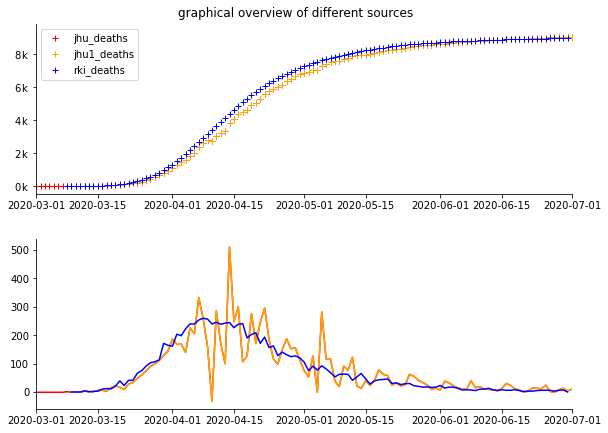

In [6]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("graphical overview of different sources")
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,0])
bx = fig.add_subplot(gs[1,0])

i = 0
color=["red","orange","blue"]
keys = ["jhu_deaths","jhu1_deaths","rki_deaths"]
for k in keys:
    d,t = sources[k]
    ax.plot(t,d,'+',label=k,color=color[i])
    bx.plot(t[1:],np.diff(d),label=k,color=color[i])
    i+=1
    
ax.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
bx.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
ax.legend()
    
for tx in [ax,bx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        

In [76]:
# Test simple SIR-Fit beta,gamma,N,I0

def FitSIRModel(data,l=90,initial={},I0=None,fit_differences=False):
    """
    Fit SIR model using HamiltonianMonteCarlo No-UTurn-Sampler 
        fit_0 : Allow fitting I0 else I0 = 1
        fit_differences : False # keep it that way until daily differences are of interest and not total numbers
    """
    with pm.Model() as model:
        # Setup Priors for beta,gamma
        beta = pm.Lognormal(name="beta",
                        mu=tt.log(tt.cast(.25,dtype='float64')),
                        sigma=tt.cast(.9,dtype='float64')) # Choose both beta and gamma wide enough
        gamma = pm.Lognormal(name="gamma",
                         mu=tt.log(tt.cast(.13,dtype='float64')),
                         sigma=tt.cast(.9,dtype='float64'))
        beta = tt.clip(beta,gamma,1e3) # Ensure positive initial growth, improves sampling
    
#        N = tt.cast(83e6,dtype='float64')
        N = pm.Lognormal(name="N",
                         mu=tt.log(tt.cast(200000,dtype='float64')),
                         sigma=tt.cast(.4,dtype='float64'))
        S0 = N
        if I0 == None: # Eiher fit or don't fit I0
            I0 = pm.Lognormal(name="I0",
                      mu=tt.log(tt.cast(20,dtype='float64')),
                      sigma=tt.cast(.5,dtype="float64")
                     )
        else:
            I0 = tt.cast(I0,dtype='float64')
    
        R0 = tt.cast(0.,dtype='float64')
    
        # Run the Model
        S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(beta,gamma,N,S0,I0,R0,l=l)
        # Store Model output in Trace
        pm.Deterministic("S_t",S_t)
        pm.Deterministic("I_t",I_t)
        pm.Deterministic("R_t",R_t)
        pm.Deterministic("dS",dS)
        pm.Deterministic("dR",dR)
        
        # Loglike-estimate
        if fit_differences: # Fit differences, which might me more suitable for the Sampler
            est = -dS
            sigma_obs = pm.HalfCauchy( name="sigma", beta=10 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est,
                    sigma=tt.abs_(est + 1) ** 0.5 * sigma_obs,
                    observed=np.diff(data[:l+1])
            )
        else: # Leads to tighter fit to the non-differentiated data
#            est_deaths = R_t
            est = tt.cumsum(-dS)[30:]
            pm.Deterministic("est",est)
            sigma_obs = pm.HalfCauchy( name="sigma", beta=40 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est,
                    sigma=tt.abs_(est + 1) ** 0.5 * sigma_obs,
                    observed=data[30:l]
            )
        
        # Handle Chained sampling reusing previous fit as starting-point
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=1200,tune=1200,cores=4,chains=4)#,max_treedepth=16)
        return trace

In [72]:
l = 80
trace = FitSIRModel(data,l=l,I0=None)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_000 tune and 1_200 draw iterations (4_000 + 4_800 draws total) took 866 seconds.
The acceptance probability does not match the target. It is 0.5807678762205183, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6348182781273829, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


0.28068818158704434 [0.22430166 0.32703429]
0.09561968186921968 [0.04141548 0.13695635]
11.334874055176378 [ 6.24848178 18.86289783]
119910.10401010078 [109895.37449019 130432.01252508]


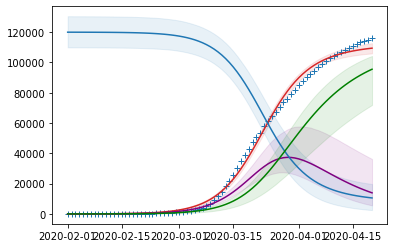

In [75]:
l = 80
plt.plot(ts[:l],data[:l],"+")
#plt.plot(ts[:l],np.mean(trace.dI,axis=0))
plt.plot(ts[:l],np.mean(np.cumsum(-trace.dS,axis=1),axis=0),color="tab:red")
plt.fill_between(ts[:l],*np.percentile(np.cumsum(-trace.dS,axis=1),axis=0,q=(2.5,97.5)),alpha=.1,color="tab:red")
#plt.plot(ts[:l],np.mean(trace.est,axis=0))

plt.plot(ts[:l],np.mean(trace.I_t,axis=0),color="purple")
plt.fill_between(ts[:l],*np.percentile(trace.I_t,axis=0,q=(2.5,97.5)),alpha=.1,color="purple")

plt.plot(ts[:l],np.mean(trace.S_t,axis=0),color="tab:blue")
plt.fill_between(ts[:l],*np.percentile(trace.S_t,axis=0,q=(2.5,97.5)),color="tab:blue",alpha=.1)

plt.plot(ts[:l],np.mean(trace.R_t,axis=0),color="green")
plt.fill_between(ts[:l],*np.percentile(trace.R_t,axis=0,q=(2.5,97.5)),alpha=.1,color="green")

print(np.mean(trace.beta),np.percentile(trace.beta,q=(2.5,97.5)))
print(np.mean(trace.gamma),np.percentile(trace.gamma,q=(2.5,97.5)))
print(np.mean(trace.I0),np.percentile(trace.I0,q=(2.5,97.5)))
print(np.mean(trace.N),np.percentile(trace.N,q=(2.5,97.5)))

with open("traces/sir_80","wb+") as f:
    pickle.dump(ts,f)
    pickle.dump(data,f)
    pickle.dump(trace,f)

0.21053082050651312 [0.18812315 0.23075235]
0.03632423417742948 [0.01118904 0.05771404]
112810.19065732979 [107720.64822525 117377.78587204]


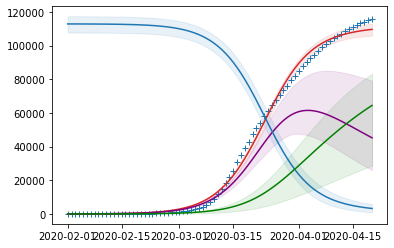

In [40]:
plt.plot(ts[:l],data[:l],"+")
#plt.plot(ts[:l],np.mean(trace.dI,axis=0))
plt.plot(ts[:l],np.mean(np.cumsum(-trace.dS,axis=1),axis=0),color="tab:red")
plt.fill_between(ts[:l],*np.percentile(np.cumsum(-trace.dS,axis=1),axis=0,q=(2.5,97.5)),alpha=.1,color="tab:red")
#plt.plot(ts[:l],np.mean(trace.est,axis=0))

plt.plot(ts[:l],np.mean(trace.I_t,axis=0),color="purple")
plt.fill_between(ts[:l],*np.percentile(trace.I_t,axis=0,q=(2.5,97.5)),alpha=.1,color="purple")

plt.plot(ts[:l],np.mean(trace.S_t,axis=0),color="tab:blue")
plt.fill_between(ts[:l],*np.percentile(trace.S_t,axis=0,q=(2.5,97.5)),color="tab:blue",alpha=.1)

plt.plot(ts[:l],np.mean(trace.R_t,axis=0),color="green")
plt.fill_between(ts[:l],*np.percentile(trace.R_t,axis=0,q=(2.5,97.5)),alpha=.1,color="green")

print(np.mean(trace.beta),np.percentile(trace.beta,q=(2.5,97.5)))
print(np.mean(trace.gamma),np.percentile(trace.gamma,q=(2.5,97.5)))
#print(np.mean(trace.I0),np.percentile(trace.I0,q=(2.5,97.5)))
print(np.mean(trace.N),np.percentile(trace.N,q=(2.5,97.5)))


In [77]:
def SIRSeries(data,start=30,end=120,fit_I0=True):
    estimates = {}
    
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'beta':np.mean(tr.beta),'gamma':np.mean(tr.gamma),'N':np.mean(tr.N)}
        print(l,initial)
        if fit_I0 and tr != None:
            initial['I0'] = np.mean(tr.I0)
            
        tr = FitSIRModel(data=data,l=l,initial=initial,I0=None)
        
        estimates[l] = {'beta':tr.beta,'gamma':tr.gamma,'N':tr.N,"est":np.cumsum(-tr.dS,axis=1)}
        if fit_I0:
            estimates[l]["I0"] = tr.I0
    return estimates

sir_est = SIRSeries(data,60,90)

60 {}


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 8300
Interrupted at 8,299 [4%]: Average Loss = 425.51
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 521 seconds.
The acceptance probability does not match the target. It is 0.6961661778279459, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.717808797074249, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


61 {'beta': 0.27716299418485607, 'gamma': 0.03992774604692791, 'N': 84972.63351613181}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 567 seconds.
The acceptance probability does not match the target. It is 0.681352854812306, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


62 {'beta': 0.28249370357823783, 'gamma': 0.047807156404099285, 'N': 87240.47809219913}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 582 seconds.
The acceptance probability does not match the target. It is 0.6984088390475711, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5730277056913161, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


63 {'beta': 0.2767112522272197, 'gamma': 0.04783643739724085, 'N': 89324.64452461188}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 576 seconds.
The acceptance probability does not match the target. It is 0.4129100825222463, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.653485812780623, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


64 {'beta': 0.2809214477090912, 'gamma': 0.056439086520644964, 'N': 92671.89450584035}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 653 seconds.
The acceptance probability does not match the target. It is 0.6425421904012522, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4173427889850534, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


65 {'beta': 0.27487990561542996, 'gamma': 0.05541894031352906, 'N': 94459.96130499661}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 662 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.26530596177533494, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.631704978756074, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


66 {'beta': 0.2753691178503995, 'gamma': 0.05813228491702751, 'N': 96072.34737053275}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 827 seconds.
The acceptance probability does not match the target. It is 0.5976360653159055, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


67 {'beta': 0.27266103988119594, 'gamma': 0.057599774300355455, 'N': 97521.14201812535}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 781 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5037755326921859, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.533584395104393, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.644206128190497, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


68 {'beta': 0.28317091814447165, 'gamma': 0.07186582619319594, 'N': 100666.34072818136}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 718 seconds.
The acceptance probability does not match the target. It is 0.6448794805285242, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


69 {'beta': 0.27534906065030906, 'gamma': 0.06499360450572766, 'N': 100885.23654214032}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 620 seconds.
The acceptance probability does not match the target. It is 0.6288664355835256, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3215620793723423, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7134816546530783, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


70 {'beta': 0.27175312622118963, 'gamma': 0.06499015328554049, 'N': 102514.1353478349}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 506 seconds.
The acceptance probability does not match the target. It is 0.5369972377769492, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43821602712256585, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.434183878360782, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5942508029400746, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


71 {'beta': 0.2817122549434919, 'gamma': 0.07629336464607363, 'N': 105314.10093569633}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 691 seconds.
The acceptance probability does not match the target. It is 0.7212846047604305, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.041064204814048814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.697001142773434, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


72 {'beta': 0.2905309548765383, 'gamma': 0.08847275187144253, 'N': 108785.70115404802}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 681 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.19165465671787899, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7209880331136991, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5193004354513868, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


73 {'beta': 0.29805646809721226, 'gamma': 0.09556270974655899, 'N': 110581.1851880867}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 702 seconds.
The acceptance probability does not match the target. It is 0.5486214978973976, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7090609982077175, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


74 {'beta': 0.2755763245751378, 'gamma': 0.07564110683107816, 'N': 109030.49082863201}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 790 seconds.
The acceptance probability does not match the target. It is 0.883618427940584, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6084389187385753, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7073385082856141, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


75 {'beta': 0.28573915049956866, 'gamma': 0.08903587656777265, 'N': 112368.38605172605}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 760 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.0971273167289392, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


76 {'beta': 0.2860599727659079, 'gamma': 0.09078629887088499, 'N': 113702.43905959418}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 665 seconds.
The acceptance probability does not match the target. It is 0.5450984374971406, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7153628254992279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6793339205253767, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


77 {'beta': 0.2705407548605932, 'gamma': 0.07840192010385998, 'N': 113192.4766725262}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 800 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


78 {'beta': 0.28466155328713294, 'gamma': 0.09327860165683911, 'N': 116315.57653391242}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 808 seconds.
The acceptance probability does not match the target. It is 0.6247271779652355, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


79 {'beta': 0.291139797746841, 'gamma': 0.10132287135335304, 'N': 118664.68128644372}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 773 seconds.
The acceptance probability does not match the target. It is 0.4921369616980575, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5130149971148901, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


80 {'beta': 0.27864970895742774, 'gamma': 0.09295299226235842, 'N': 118765.38526371174}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 783 seconds.
The acceptance probability does not match the target. It is 0.5042083576960124, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6499757329509324, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6694255573224162, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


81 {'beta': 0.2933308885983386, 'gamma': 0.10728855702515117, 'N': 121696.46533127516}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 778 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49904534214115176, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.26889026812985756, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


82 {'beta': 0.3037887498476106, 'gamma': 0.1185447333625866, 'N': 124629.25854641094}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 829 seconds.
The acceptance probability does not match the target. It is 0.5283948978765506, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


83 {'beta': 0.293388109521028, 'gamma': 0.10913714840444072, 'N': 123672.64860068589}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 836 seconds.
The acceptance probability does not match the target. It is 0.640463886129604, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7050961769371199, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


84 {'beta': 0.28789113234441077, 'gamma': 0.10525618819018147, 'N': 123813.44890658311}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 826 seconds.
The acceptance probability does not match the target. It is 0.6803927625818335, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


85 {'beta': 0.2816312990638238, 'gamma': 0.09974438153348271, 'N': 123181.33377822921}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 829 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.23041318116709525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34282655409450885, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


86 {'beta': 0.2961604088113461, 'gamma': 0.11958548059690997, 'N': 129705.78190640564}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 721 seconds.
The acceptance probability does not match the target. It is 0.4309515584256188, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


87 {'beta': 0.2800923336334625, 'gamma': 0.10055417994402271, 'N': 124719.9098156265}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 739 seconds.
The acceptance probability does not match the target. It is 0.5045739606978334, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7110486263885615, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


88 {'beta': 0.28067325856199915, 'gamma': 0.10254791663586678, 'N': 125804.3705189854}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 817 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


89 {'beta': 0.2814819660573081, 'gamma': 0.10422704577746893, 'N': 126985.69615196894}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 814 seconds.
The acceptance probability does not match the target. It is 0.7109416268632234, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


90 {'beta': 0.2780536377856956, 'gamma': 0.10186065418182716, 'N': 127055.22911039066}


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 795 seconds.
The acceptance probability does not match the target. It is 0.6492648044991072, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5938503949840662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6324959330278387, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [79]:
with open("estimates/sir_symptomatic_%d"%time.time(),"wb+") as f:
    pickle.dump(sir_est,f)

for k,v in sir_est.items():
#    print(k,v["ssd"])
    for p in ['beta','gamma','N','I0']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))

	 beta 0.27716299418485607 [0.24106119 0.24595033 0.27741101 0.30503453 0.31530135]
	 gamma 0.03992774604692791 [0.01121674 0.01388003 0.0397181  0.06757875 0.07041206]
	 N 84972.63351613181 [79311.53210284 80168.0572401  84656.39258299 90654.19024146
 93429.67959362]
	 I0 2.4948927409434143 [1.32530296 1.42332743 2.28753355 4.39118317 4.92218121]
	 beta 0.28249370357823783 [0.23939566 0.24469679 0.28002433 0.33182442 0.33832027]
	 gamma 0.047807156404099285 [0.01193439 0.01485432 0.04559262 0.09419724 0.09883398]
	 N 87240.47809219913 [81283.39394316 82196.72460701 86803.1045982  93295.67183267
 96697.92837902]
	 I0 2.654964138970085 [1.34501659 1.41851592 2.39256554 4.6471623  5.40629873]
	 beta 0.2767112522272197 [0.23437423 0.2400286  0.27522972 0.31447257 0.32237394]
	 gamma 0.04783643739724085 [0.01154751 0.01500793 0.04562251 0.08528517 0.09482094]
	 N 89324.64452461188 [82987.88528584 83762.63199682 88694.37548383 95570.18758408
 97350.66180582]
	 I0 3.1865295039408172 [1.69224

In [80]:
def FitGompertz(data,l=90,initial={}):
    with pm.Model() as model:
        a = pm.Lognormal(name="a",
                    mu=tt.log(tt.cast(1e5,dtype='float64')),
                    sigma=tt.cast(.6,dtype='float64'))
        b = pm.Lognormal(name="b",
                    mu=tt.log(tt.cast(11,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
        c = pm.Lognormal(name="c",
                    mu=tt.log(tt.cast(.07,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
    
        est = Gompertz(a,b,c,l)
        est_deaths = pm.Deterministic("deaths",est)
    
        sigma_obs = pm.HalfCauchy( name="sigma", beta=40 )
        pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
        )
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=1200,tune=2000,cores=4,chains=4)
        return trace

In [67]:
trace = FitGompertz(data,l=80)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 23 seconds.
The acceptance probability does not match the target. It is 0.7176451704288611, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


132632.8814172108 [125886.95287638 140812.72750622]
39.648429060032996 [32.90205648 47.58661907]
0.07433682324892915 [0.06922913 0.07912472]
273379417.6567731


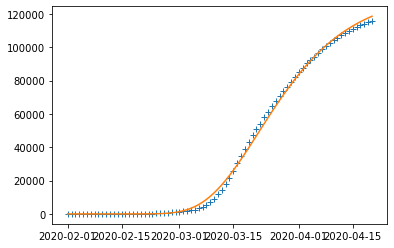

In [71]:
l=80
plt.plot(ts[:l],data[:l],"+")
#plt.plot(ts[:l],np.mean(trace.dI,axis=0))
plt.plot(ts[:l],np.mean(trace.deaths,axis=0))

print(np.median(trace.a),np.percentile(trace.a,q=(2.5,97.5)))
print(np.median(trace.b),np.percentile(trace.b,q=(2.5,97.5)))
print(np.median(trace.c),np.percentile(trace.c,q=(2.5,97.5)))

print( np.sum(np.power(data[:l]-np.mean(trace.deaths[:l],axis=0),2 ) ) )


In [81]:
def GompertzSeries(data,start=30,end=120):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'a':np.mean(tr.a),'b':np.mean(tr.b),'c':np.mean(tr.c)}
        tr = FitGompertz(data,l=l,initial=initial)
#        ssd = np.sum(np.power(data[:l]-np.mean(tr.deaths,axis=0),2))
        estimates[l] = {'a':tr.a,'b':tr.b,'c':tr.c,"est":tr.deaths}
    return estimates

gomp_est = GompertzSeries(data,60,90)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 10300
Interrupted at 10,299 [5%]: Average Loss = 625.05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.8798754729743911, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 23 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8847267411021471, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9013783806433434, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.5994183578007879, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 22 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8947447011371893, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8817860036712155, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7036201606905094, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.8794031656888289, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8902184428434956, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6658228978701186, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8794508668080527, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6003343998912369, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8819404722849666, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.892216385347103, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6064290676374551, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8808826578060306, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.8840039144555374, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.7106621496411943, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8886323297782782, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.576372351792908, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.7058617561981682, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.6794816476455217, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8930855116483627, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [82]:
with open("estimates/gomp_symptomatic_%d"%time.time(),"wb+") as f:
    pickle.dump(gomp_est,f)

for k,v in gomp_est.items():
    print(k,v["ssd"])
    for p in ['a','b','c']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))


KeyError: 'ssd'

In [ ]:
trace = FitGompertz(l=30)
plt.plot(ts1[:l],deaths1[:l],"+")
plt.plot(ts1[:l],trace.deaths[0])
plt.fill_between(ts1[:l],*np.percentile(trace.deaths,axis=0,q=(2.5,97.5)),color="orange",alpha=.2)

gomp_est = np.mean(trace.deaths,axis=0)
print(SSD(deaths1[:1],gomp_est))
